# Language Classifier
## Set up the environment

In [1]:
# Set up the environment
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import soundfile as sf

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Input, Flatten, Dropout
from keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("All set up!")

You should consider upgrading via the 'pip install --upgrade pip' command.
All set up!


In [2]:
# Set constants
SAMP_RATE = 16000  #Defined in augment package
BATCH_SIZE = 32  #Defined in augment package
CLF = 'lang10'

In [3]:
meta = pd.read_csv('processed.csv', index_col='speakerid')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


# Create data generators

## Load the VGGish model
The model needs to be instantiated before the dataset generator is called.

In [4]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

## Create lists of filenames and paths to feed the generators.

Since the audio files are divided into folders, we can just generate lists of the contents of the folders.

Following the example from https://keras.io/examples/audio/speaker_recognition_using_cnn/

In [5]:
# Dataset generation from Keras.IO example
# https://keras.io/examples/audio/speaker_recognition_using_cnn/

from pathlib import Path
# Get the list of audio file paths along with their corresponding labels
DATASET_ROOT = "storage/data/lang10"
TRAIN_SUBFOLDER = "train"
VAL_SUBFOLDER = "validation"
TEST_SUBFOLDER = "test/test_data"

DATASET_TRAIN_PATH = os.path.join(DATASET_ROOT, TRAIN_SUBFOLDER)
DATASET_VAL_PATH = os.path.join(DATASET_ROOT, VAL_SUBFOLDER)
DATASET_TEST_PATH = os.path.join(DATASET_ROOT, TEST_SUBFOLDER)

SHUFFLE_SEED = 38
SAMP_RATE = 16000

class_names = os.listdir(DATASET_TRAIN_PATH)
class_names.remove('.ipynb_checkpoints')
print("Our class names: {}".format(class_names,))

Our class names: ['russian', 'arabic', 'turkish', 'korean', 'german', 'dutch', 'spanish', 'french', 'english', 'portuguese', 'mandarin']


In [6]:
num_class = len(class_names)
print(num_class)

11


In [7]:
# Process training data
train_paths = []
train_labels = []
for label, name in enumerate(class_names):
    print("Processing language {}".format(name,))
    dir_path = Path(DATASET_TRAIN_PATH) / name
    language_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    train_paths += language_sample_paths
    train_labels += [label] * len(language_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(train_paths), len(class_names))
)

Processing language russian
Processing language arabic
Processing language turkish
Processing language korean
Processing language german
Processing language dutch
Processing language spanish
Processing language french
Processing language english
Processing language portuguese
Processing language mandarin
Found 1606 files belonging to 11 classes.


In [8]:
# Process validation data
validation_paths = []
val_labels = []
for label, name in enumerate(class_names):
    print("Processing language {}".format(name,))
    dir_path = Path(DATASET_VAL_PATH) / name
    language_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    validation_paths += language_sample_paths
    val_labels += [label] * len(language_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(validation_paths), len(class_names))
)

Processing language russian
Processing language arabic
Processing language turkish
Processing language korean
Processing language german
Processing language dutch
Processing language spanish
Processing language french
Processing language english
Processing language portuguese
Processing language mandarin
Found 536 files belonging to 11 classes.


In [9]:
# Process testing data
testing_filenames = os.listdir(DATASET_TEST_PATH)
testing_paths = []
test_labels = []

label_dict = {}
for label, name in enumerate(class_names):
    label_dict[name] = label

for filename in testing_filenames:
    filepath =  os.path.join(DATASET_TEST_PATH, filename)
    testing_paths.append(filepath)
    fname = filename.split('.')[0].rstrip('0123456789')
    test_labels.append(label_dict[fname])

In [10]:
# Shuffle the order of the traning and validation datasets and labels
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)

rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(validation_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(val_labels)

rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(testing_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_labels)

## One-hot encode the labels

In [11]:
train_onehot = tf.keras.backend.one_hot(train_labels, num_classes = len(class_names))
val_onehot = tf.keras.backend.one_hot(val_labels, num_classes = len(class_names))
test_onehot = tf.keras.backend.one_hot(test_labels, num_classes = len(class_names))

print(type(train_onehot) )
print(train_onehot.shape)
print(train_onehot[0])

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1606, 11)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(11,), dtype=float32)


## Get sample sizes and number of batches for each dataset

In [12]:
# Print sizes of data splits
print("Number of training samples: ", len(train_paths))
print("Number of validation samples: ", len(validation_paths))
print("Number of testing samples: ", len(testing_paths))

Number of training samples:  1606
Number of validation samples:  536
Number of testing samples:  373


In [13]:
# Calculate how many dataset batches to generate
train_steps = np.int(np.ceil(len(train_paths)/BATCH_SIZE)) -1
val_steps = np.int(np.ceil(len(validation_paths)/BATCH_SIZE))-1
eval_steps = np.int(np.ceil(len(testing_paths)/BATCH_SIZE))-1

print("training_steps_per_epoch = ", train_steps)
print("validation_steps = ", val_steps)
print("evaluation_steps = ", eval_steps)

training_steps_per_epoch =  50
validation_steps =  16
evaluation_steps =  11


## Define the data generator
Run a test batch to make sure the generator produces the right shapes.

In [14]:
def tf_data_generator(file_list, label_list, batch_size=32):
    '''
    Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    label_list - list of the labels associated with the files
    batch_size - how many files to process at a time
    '''
    i = 1
    shuff_seed = 42
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=1
            rng = np.random.RandomState(shuff_seed)
            rng.shuffle(file_list)
            rng = np.random.RandomState(shuff_seed)
            rng.shuffle(label_list)
            shuff_seed += 1
        else:
            file_chunk = file_list[(i-1)*batch_size:i*batch_size]
            labels = label_list[(i-1)*batch_size:i*batch_size, :]
            data = []

            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [15]:
dataset_check = tf.data.Dataset.from_generator(tf_data_generator,
                                         args = [train_paths[:2*BATCH_SIZE], train_onehot[:2*BATCH_SIZE], BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) )

In [16]:
# Check shape and size of dataset batches
for data, labels in dataset_check.take(2):
    print(data.shape)
    print(labels.shape)

(32, 10, 128)
(32, 11)
(32, 10, 128)
(32, 11)


## Generate the datasets

In [17]:
train_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [train_paths, train_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) ) 
validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [validation_paths, val_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) )
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [testing_paths, test_onehot, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,11)) ) 

# Set model constants

These models will all have one hidden, dense layer, with various number of nodes in the hidden layer.  After the hidden layer, the data will pass through a dropout layer and a flatten layer before being passed to the output layer.

The activiation function for all models with be "relu."

INPUT layer
Dense layer - variable number of nuerons/nodes
DROPOUT layer = 0.5
FLATTEN layer
OUTPUT layer = 11 nodes, (number of classes), softmax activation.

In [18]:
# Modified from https://console.paperspace.com/gcn-team/notebook/prcnk5wzd
# Set constants
BATCH_SIZE = 32
NUM_EPOCHS=100
DROPOUT = 0.5
EARLY_STOP_AFTER = 5

LOSS = 'categorical_crossentropy'
DENSE_ACTIVATION = 'relu'
FINAL_ACTIVATION = 'softmax'

TRAIN_STEPS = train_steps
VAL_STEPS = val_steps
EVAL_STEPS = eval_steps

In [19]:
def create_lang_model(n_layers, n_nodes):
    model = Sequential()
    model.add(Input(shape=(10, 128), batch_size=BATCH_SIZE ))
    
    for i in range(n_layers):
        model.add(Dense(n_nodes/(2**i), activation=DENSE_ACTIVATION))
        model.add(Dropout(DROPOUT))

    model.add(Flatten())
    # Output
    model.add(Dense(11, activation=FINAL_ACTIVATION) )

    model.compile(loss=LOSS, optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
    return model

In [20]:
def plot_accuracy(model_name, hist_df, fig_path):
    plt.plot(hist_df['accuracy'])
    plt.plot(hist_df['val_accuracy'])
    plt.title('Accuracy: {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('{}.Accuracy.png'.format(fig_path))

def plot_loss(model_name, hist_df, fig_path):
    plt.plot(hist_df['loss'])
    plt.plot(hist_df['val_loss'])
    plt.title('Loss: {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig('{}.Loss.png'.format(fig_path))

In [21]:
def evaluate_model(model, model_name, test_ds):
    # Evaluate the model
    #val_loss, val_acc, val_prec, val_recall = model.evaluate(val_ds, steps=VAL_STEPS)
    #test_loss, test_acc, test_prec, test_recall = model.evaluate(test_ds, steps=EVAL_STEPS)
    
    y_pred = model.predict(test_ds, steps=EVAL_STEPS)
    y_pred_ind = np.argmax(y_pred, axis=1)
    
    # Get 1D array of labels from test_dataset
    y_lab = np.concatenate([y for x, y in test_ds.take(EVAL_STEPS)], axis=0)
    y_lab_ind = np.argmax(y_lab, axis=1)

    fig_path = ('storage/figures/gender/{}'.format(model_name))

    conf_mat = tf.math.confusion_matrix(y_lab_ind, y_pred_ind)
    print(conf_mat)
    sns.heatmap(conf_mat, annot = True, cmap='YlGnBu')
    plt.title("Confusion matrix: {}".format(model_name))
    plt.savefig('{}.ConfusionMatrix.png'.format(fig_path))

    return y_lab, y_pred_ind

In [22]:
def run_model(n_layers, n_nodes, train_ds, val_ds, test_ds):
    
    # Create and compile the model
    model = create_lang_model(n_layers, n_nodes)
    
    model_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
    
    # Set up callbacks
    ckpt_name = '{}.ckpt'.format(model_name)
    ckpt_path = 'storage/models/lang10/{}'.format(ckpt_name)
    ckpt_dir = os.path.dirname(ckpt_path)

    ckpt = ModelCheckpoint(filepath=ckpt_path,
                           monitor='val_loss',
                           save_weights_only=False,
                           mode='auto',
                           save_best_only=True)
    
    early_stopping = EarlyStopping(patience=EARLY_STOP_AFTER)
    
    # Train the model
    hist = model.fit(train_ds, steps_per_epoch = TRAIN_STEPS, epochs=NUM_EPOCHS, 
                     validation_data=val_ds, validation_steps=VAL_STEPS,
                     callbacks=[early_stopping, ckpt])
    

    # Plot training history and save figures
    hist_df = pd.DataFrame(hist.history)
    
    fig_path = ('storage/figures/lang10/{}'.format(model_name))
    plot_accuracy(model_name, hist_df, fig_path)
    plot_loss(model_name, hist_df, fig_path)

    # Save the model
    model.save('storage/models/lang10/{}'.format(model_name))
    hist_csv_file = 'storage/models/lang10/{}.csv'.format(model_name)

    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    # Evaluate the model
    print('Validation dataset results:')
    val_loss, val_acc, val_prec, val_recall = model.evaluate(val_ds, steps=VAL_STEPS)
    print('Test dataset results:')
    test_loss, test_acc, test_prec, test_recall = model.evaluate(test_ds, steps=EVAL_STEPS)
    
    y_lab, y_pred_ind = evaluate_model(model, model_name, test_ds)
        
    print('{} complete'.format(model_name))
    
    return model, hist_df, y_lab, y_pred_ind

## Model 1
Nodes equal to 1% the size of the input
0.01 * 10 x 128 = 12

In [23]:
# Set model constants
n_layers = 1
n_nodes = int(10 * 128 * 0.01)
print(n_nodes)

model1_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model1_path = 'storage/models/lang10/{}'.format(model1_name)
ckpt1_name = '{}.ckpt'.format(model1_name)
ckpt1_path = 'storage/models/lang10/{}'.format(ckpt1_name)
ckpt1_dir = os.path.dirname(ckpt1_path)

12


Create a new model
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.5716 - accuracy: 0.0956 - precision: 0.0800 - recall: 0.0012WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 567s 11s/step - loss: 2.5716 - accuracy: 0.0956 - precision: 0.0800 - recall: 0.0012 - val_loss: 2.3968 - val_accuracy: 0.1113 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 2.3834 - accuracy: 0.1275 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 542s 11s/step - loss: 2.3834 - accuracy: 0.1275 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3845 - val_accuracy: 0.1230 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 2.3612 - accuracy: 0.1394 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 545s 11s/step - loss: 2.3612 - accuracy: 0.1394 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3716 - val_accuracy: 0.1270 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 2.3440 - accuracy: 0.1238 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 546s 11s/step - loss: 2.3440 - accuracy: 0.1238 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3668 - val_accuracy: 0.1289 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 2.3257 - accuracy: 0.1631 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 552s 11s/step - loss: 2.3257 - accuracy: 0.1631 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3641 - val_accuracy: 0.1543 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 2.2984 - accuracy: 0.1756 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 548s 11s/step - loss: 2.2984 - accuracy: 0.1756 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3381 - val_accuracy: 0.1641 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 2.2791 - accuracy: 0.1800 - precision: 0.7143 - recall: 0.0031INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 552s 11s/step - loss: 2.2791 - accuracy: 0.1800 - precision: 0.7143 - recall: 0.0031 - val_loss: 2.3325 - val_accuracy: 0.2090 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/100
50/50 [==============================] - ETA: 0s - loss: 2.2608 - accuracy: 0.1956 - precision: 0.5714 - recall: 0.0025INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 587s 12s/step - loss: 2.2608 - accuracy: 0.1956 - precision: 0.5714 - recall: 0.0025 - val_loss: 2.3187 - val_accuracy: 0.2051 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/100
50/50 [==============================] - ETA: 0s - loss: 2.2288 - accuracy: 0.2031 - precision: 0.6364 - recall: 0.0088INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 587s 12s/step - loss: 2.2288 - accuracy: 0.2031 - precision: 0.6364 - recall: 0.0088 - val_loss: 2.2906 - val_accuracy: 0.1953 - val_precision: 1.0000 - val_recall: 0.0039
Epoch 10/100
50/50 [==============================] - ETA: 0s - loss: 2.2099 - accuracy: 0.2150 - precision: 0.5862 - recall: 0.0106INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 563s 11s/step - loss: 2.2099 - accuracy: 0.2150 - precision: 0.5862 - recall: 0.0106 - val_loss: 2.2743 - val_accuracy: 0.2129 - val_precision: 0.5000 - val_recall: 0.0020
Epoch 11/100
50/50 [==============================] - 563s 11s/step - loss: 2.1776 - accuracy: 0.2225 - precision: 0.6286 - recall: 0.0137 - val_loss: 2.2770 - val_accuracy: 0.2168 - val_precision: 0.7500 - val_recall: 0.0059
Epoch 12/100
50/50 [==============================] - ETA: 0s - loss: 2.1584 - accuracy: 0.2331 - precision: 0.7647 - recall: 0.0244INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 563s 11s/step - loss: 2.1584 - accuracy: 0.2331 - precision: 0.7647 - recall: 0.0244 - val_loss: 2.2707 - val_accuracy: 0.2090 - val_precision: 0.6667 - val_recall: 0.0117
Epoch 13/100
50/50 [==============================] - ETA: 0s - loss: 2.1275 - accuracy: 0.2475 - precision: 0.7037 - recall: 0.0237INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 558s 11s/step - loss: 2.1275 - accuracy: 0.2475 - precision: 0.7037 - recall: 0.0237 - val_loss: 2.2676 - val_accuracy: 0.2266 - val_precision: 0.8889 - val_recall: 0.0156
Epoch 14/100
50/50 [==============================] - ETA: 0s - loss: 2.0826 - accuracy: 0.2637 - precision: 0.7742 - recall: 0.0300INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5.ckpt/assets


50/50 [==============================] - 543s 11s/step - loss: 2.0826 - accuracy: 0.2637 - precision: 0.7742 - recall: 0.0300 - val_loss: 2.2658 - val_accuracy: 0.2266 - val_precision: 0.7143 - val_recall: 0.0195
Epoch 15/100
50/50 [==============================] - 535s 11s/step - loss: 2.0820 - accuracy: 0.2713 - precision: 0.6667 - recall: 0.0338 - val_loss: 2.2705 - val_accuracy: 0.2285 - val_precision: 0.6667 - val_recall: 0.0078
Epoch 16/100
50/50 [==============================] - 517s 10s/step - loss: 2.0470 - accuracy: 0.2688 - precision: 0.6892 - recall: 0.0319 - val_loss: 2.2667 - val_accuracy: 0.2363 - val_precision: 0.5385 - val_recall: 0.0137
Epoch 17/100
50/50 [==============================] - 531s 11s/step - loss: 2.0278 - accuracy: 0.2831 - precision: 0.7158 - recall: 0.0425 - val_loss: 2.2753 - val_accuracy: 0.2168 - val_precision: 0.6250 - val_recall: 0.0098
Epoch 18/100
50/50 [==============================] - 600s 12s/step - loss: 2.0114 - accuracy: 0.2862 - preci

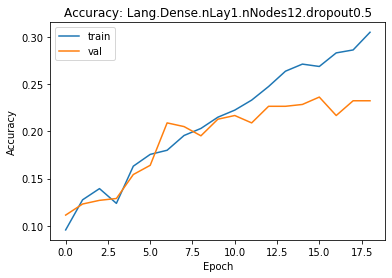

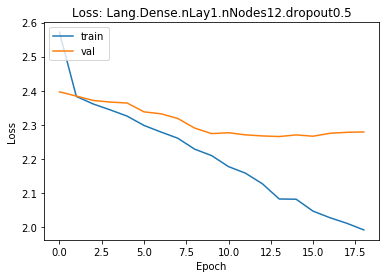

INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes12.dropout0.5/assets


Validation dataset results:
16/16 [==============================] - 156s 10s/step - loss: 2.2791 - accuracy: 0.2324 - precision: 0.5000 - recall: 0.0117
Test dataset results:
11/11 [==============================] - 101s 9s/step - loss: 2.2549 - accuracy: 0.2330 - precision: 0.6250 - recall: 0.0142
tf.Tensor(
[[ 1  9  0  0  0  0  4  1  2  4  7]
 [ 0 27  0  2  0  4  3  0  2  0 17]
 [ 1  2  2  3  1  2  4  1  1  2  2]
 [ 2 10  1  0  0  0  4  1  2  1 10]
 [ 0  0  1  2  0  0  2  0  5  2  3]
 [ 0  4  1  0  1  3  5  0  5  0  6]
 [ 1  8  5  0  2  0 10  1  8  2  5]
 [ 0  8  0  1  0  0  6  4  2  2  9]
 [ 0  2  0  4  0  0  1  1 19  2  1]
 [ 1  7  1  3  0  0  2  5  2  1  6]
 [ 0  2  4  3  0  1  8  5  3  4 15]], shape=(11, 11), dtype=int32)
Lang.Dense.nLay1.nNodes12.dropout0.5 complete


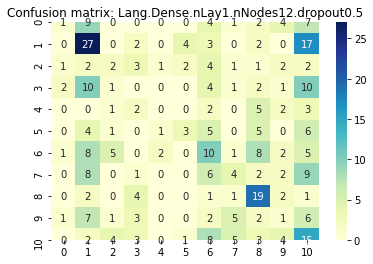

In [24]:
if os.path.isdir(model1_path):
    model1 = tf.keras.models.load_model(model1_path)
    print("Saved model loaded")
    model1.summary()
elif os.path.isdir(ckpt1_path):
    model1 = create_lang_model(n_layers, n_nodes)
    model1.load_weights(ckpt1_path)
    print("Model weights loaded")
    model1.summary()
else:
    print("Create a new model")
    model1, hist1, y1_lab, y1_pred = run_model(n_layers, n_nodes, train_dataset, validation_dataset, test_dataset)

In [34]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 10, 12)              1548      
_________________________________________________________________
dropout (Dropout)            (32, 10, 12)              0         
_________________________________________________________________
flatten (Flatten)            (32, 120)                 0         
_________________________________________________________________
dense_1 (Dense)              (32, 11)                  1331      
Total params: 2,879
Trainable params: 2,879
Non-trainable params: 0
_________________________________________________________________


### Notes on Model 1 
One dense layer with 12 nodes.

Original - Trained for 12 epochs, best values at epoch 7.
Corrected - Trained for 19 epochs, best values at epoch 12.

# Model 2
Nodes equal to 10% the size of the (2D) input: 
0.1 * 10 x 128 = 128

In [29]:
# Set model constants
n_layers = 1
n_nodes = int(10 * 128 * 0.1)
print(n_nodes)

model2_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model2_path = 'storage/models/lang10/{}'.format(model2_name)
ckpt2_name = '{}.ckpt'.format(model2_name)
ckpt2_path = 'storage/models/lang10/{}'.format(ckpt2_name)
ckpt2_dir = os.path.dirname(ckpt2_path)

128


Create a new model
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.4040 - accuracy: 0.1475 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 641s 13s/step - loss: 2.4040 - accuracy: 0.1475 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.2993 - val_accuracy: 0.1797 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 2.1824 - accuracy: 0.2306 - precision: 0.7500 - recall: 0.0037INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 645s 13s/step - loss: 2.1824 - accuracy: 0.2306 - precision: 0.7500 - recall: 0.0037 - val_loss: 2.2779 - val_accuracy: 0.2012 - val_precision: 0.3333 - val_recall: 0.0020
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 2.0535 - accuracy: 0.2900 - precision: 0.7500 - recall: 0.0206INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 634s 13s/step - loss: 2.0535 - accuracy: 0.2900 - precision: 0.7500 - recall: 0.0206 - val_loss: 2.2491 - val_accuracy: 0.2188 - val_precision: 0.7143 - val_recall: 0.0098
Epoch 4/100
50/50 [==============================] - 607s 12s/step - loss: 1.9409 - accuracy: 0.3256 - precision: 0.8000 - recall: 0.0475 - val_loss: 2.2864 - val_accuracy: 0.1973 - val_precision: 0.8462 - val_recall: 0.0215
Epoch 5/100
50/50 [==============================] - 607s 12s/step - loss: 1.8283 - accuracy: 0.3837 - precision: 0.7589 - recall: 0.0669 - val_loss: 2.3209 - val_accuracy: 0.1992 - val_precision: 0.6286 - val_recall: 0.0430
Epoch 6/100
50/50 [==============================] - 607s 12s/step - loss: 1.7511 - accuracy: 0.3906 - precision: 0.7941 - recall: 0.1013 - val_loss: 2.3002 - val_accuracy: 0.2051 - val_precision: 0.6000 - val_recall: 0.0293
Epoch 7/100
50/50 [==============================] - 557s 11s/step - loss: 1.6786 - accuracy: 0.4375 - precision

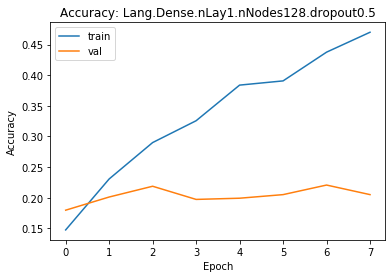

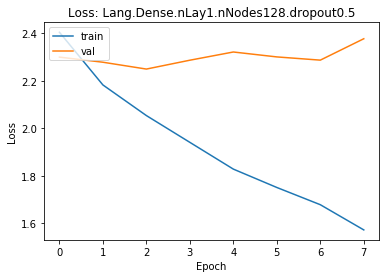

INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay1.nNodes128.dropout0.5/assets


Validation dataset results:
16/16 [==============================] - 131s 8s/step - loss: 2.3766 - accuracy: 0.2051 - precision: 0.5455 - recall: 0.0469
Test dataset results:
11/11 [==============================] - 86s 8s/step - loss: 2.3230 - accuracy: 0.2386 - precision: 0.5000 - recall: 0.0739
tf.Tensor(
[[ 1  2  2  0  3  0  4  4  1  3  8]
 [ 0 26  0  0  2  6  4  0  3  1 13]
 [ 1  2  2  2  1  4  4  1  1  1  2]
 [ 5  4  2  4  0  3  4  1  1  3  4]
 [ 1  0  0  0  0  1  3  2  4  3  1]
 [ 1  1  1  0  1 12  1  1  3  2  2]
 [ 3  1  3  0  4  2  6  2 10  2  9]
 [ 2  4  1  2  1  1  9  3  3  2  4]
 [ 1  1  0  1  0  3  2  0 15  0  7]
 [ 7  3  1  3  1  1  1  2  4  1  4]
 [ 1  0  3  5  1  5  9  3  3  1 14]], shape=(11, 11), dtype=int32)
Lang.Dense.nLay1.nNodes128.dropout0.5 complete


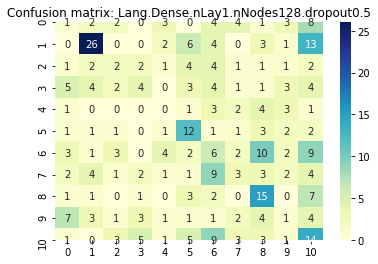

In [30]:
if os.path.isdir(model2_path):
    model2 = tf.keras.models.load_model(model2_path)
    print("Saved model loaded")
    model2.summary()
elif os.path.isdir(ckpt2_path):
    model2 = create_lang_model(n_layers, n_nodes)
    model2.load_weights(ckpt2_path)
    print("Model weights loaded")
    model2.summary()
else:
    print("Create a new model")
    model2, hist2, y2_lab, y2_pred = run_model(n_layers, n_nodes, train_dataset, validation_dataset, test_dataset)

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (32, 10, 128)             16512     
_________________________________________________________________
dropout_1 (Dropout)          (32, 10, 128)             0         
_________________________________________________________________
flatten_1 (Flatten)          (32, 1280)                0         
_________________________________________________________________
dense_3 (Dense)              (32, 11)                  14091     
Total params: 30,603
Trainable params: 30,603
Non-trainable params: 0
_________________________________________________________________


### Notes on Model 2 
One dense layer with 128 nodes.

Original - Trained for 9 epochs, best values at epoch 4.
Revised - Trained for 8, best values at epoch 3.

Evaluation results below based on final trained model.

- validation: loss: 2.3190 - accuracy: 0.1937 - precision: 0.4909 - recall: 0.0562
- testing: loss: 2.3532 - accuracy: 0.2301 - precision: 0.4603 - recall: 0.0824

# Model 3
2 layers, first with 128, second with 64

In [31]:
# Set model constants
n_layers = 2
n_nodes = int(10 * 128 * 0.1)
print(n_nodes)

model3_name = 'Lang.Dense.nLay{}.nNodes{}.dropout{}'.format(n_layers, n_nodes, DROPOUT)
model3_path = 'storage/models/lang10/{}'.format(model3_name)
ckpt3_name = '{}.ckpt'.format(model3_name)
ckpt3_path = 'storage/models/lang10/{}'.format(ckpt3_name)
ckpt3_dir = os.path.dirname(ckpt3_path)

128


Create a new model
Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.4349 - accuracy: 0.1219 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 595s 12s/step - loss: 2.4349 - accuracy: 0.1219 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3358 - val_accuracy: 0.1758 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 2.3318 - accuracy: 0.1713 - precision: 0.0000e+00 - recall: 0.0000e+00INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 621s 12s/step - loss: 2.3318 - accuracy: 0.1713 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3195 - val_accuracy: 0.1895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 2.2826 - accuracy: 0.1869 - precision: 1.0000 - recall: 0.0012INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 598s 12s/step - loss: 2.2826 - accuracy: 0.1869 - precision: 1.0000 - recall: 0.0012 - val_loss: 2.2827 - val_accuracy: 0.2285 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 2.2356 - accuracy: 0.2250 - precision: 0.6154 - recall: 0.0050INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 608s 12s/step - loss: 2.2356 - accuracy: 0.2250 - precision: 0.6154 - recall: 0.0050 - val_loss: 2.2809 - val_accuracy: 0.2129 - val_precision: 0.2000 - val_recall: 0.0020
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 2.1940 - accuracy: 0.2306 - precision: 0.6750 - recall: 0.0169INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 608s 12s/step - loss: 2.1940 - accuracy: 0.2306 - precision: 0.6750 - recall: 0.0169 - val_loss: 2.2440 - val_accuracy: 0.2246 - val_precision: 0.5556 - val_recall: 0.0098
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 2.1331 - accuracy: 0.2500 - precision: 0.7347 - recall: 0.0225INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5.ckpt/assets


50/50 [==============================] - 606s 12s/step - loss: 2.1331 - accuracy: 0.2500 - precision: 0.7347 - recall: 0.0225 - val_loss: 2.2128 - val_accuracy: 0.2363 - val_precision: 0.5556 - val_recall: 0.0098
Epoch 7/100
50/50 [==============================] - 814s 16s/step - loss: 2.0886 - accuracy: 0.2769 - precision: 0.6667 - recall: 0.0288 - val_loss: 2.2163 - val_accuracy: 0.2383 - val_precision: 0.6667 - val_recall: 0.0195
Epoch 8/100
50/50 [==============================] - 843s 17s/step - loss: 2.0410 - accuracy: 0.2944 - precision: 0.6635 - recall: 0.0431 - val_loss: 2.2323 - val_accuracy: 0.2324 - val_precision: 0.6111 - val_recall: 0.0215
Epoch 9/100
50/50 [==============================] - 613s 12s/step - loss: 1.9781 - accuracy: 0.3050 - precision: 0.6408 - recall: 0.0569 - val_loss: 2.2339 - val_accuracy: 0.2148 - val_precision: 0.5769 - val_recall: 0.0293
Epoch 10/100
50/50 [==============================] - 620s 12s/step - loss: 1.9407 - accuracy: 0.3269 - precisio

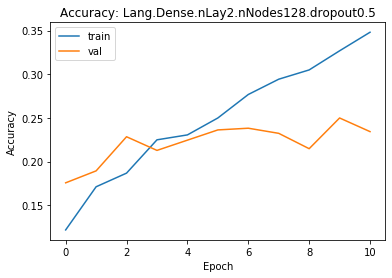

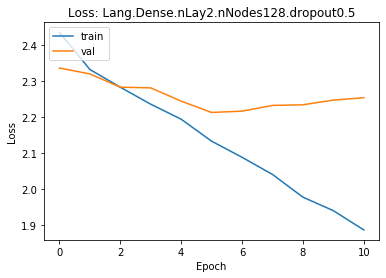

INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5/assets


INFO:tensorflow:Assets written to: storage/models/lang10/Lang.Dense.nLay2.nNodes128.dropout0.5/assets


Validation dataset results:
16/16 [==============================] - 123s 8s/step - loss: 2.2535 - accuracy: 0.2344 - precision: 0.5938 - recall: 0.0371
Test dataset results:
11/11 [==============================] - 87s 8s/step - loss: 2.2068 - accuracy: 0.2500 - precision: 0.6053 - recall: 0.0653
tf.Tensor(
[[ 0  2  1  4  0  1  7  4  1  1  7]
 [ 0 24  0  4  1  7  2  2  4  0 11]
 [ 0  1  1  4  0  3  4  0  2  1  5]
 [ 1 10  0  6  0  3  2  2  4  2  1]
 [ 0  0  0  1  0  0  5  1  5  2  1]
 [ 0  4  0  0  0 12  3  1  3  1  1]
 [ 1  2  0  6  2  1 12  3  8  0  7]
 [ 1  3  0  4  1  2 10  5  1  1  4]
 [ 0  1  0  3  0  5  2  2 13  0  4]
 [ 0  3  0  3  1  0  7  5  3  0  6]
 [ 0  2  0  8  2  4  9  1  2  2 15]], shape=(11, 11), dtype=int32)
Lang.Dense.nLay2.nNodes128.dropout0.5 complete


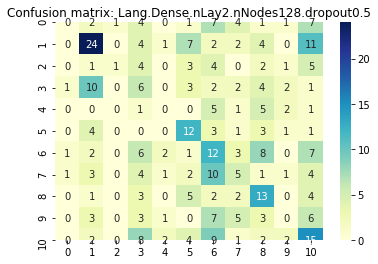

In [32]:
if os.path.isdir(model3_path):
    model3 = tf.keras.models.load_model(model3_path)
    print("Saved model loaded")
    model3.summary()
elif os.path.isdir(ckpt3_path):
    model3 = create_lang_model(n_layers, n_nodes)
    model3.load_weights(ckpt3_path)
    print("Model weights loaded")
    model3.summary()
else:
    print("Create a new model")
    model3, hist3, y3_lab, y3_pred = run_model(n_layers, n_nodes, train_dataset, validation_dataset, test_dataset)

In [36]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (32, 10, 128)             16512     
_________________________________________________________________
dropout_2 (Dropout)          (32, 10, 128)             0         
_________________________________________________________________
dense_5 (Dense)              (32, 10, 64)              8256      
_________________________________________________________________
dropout_3 (Dropout)          (32, 10, 64)              0         
_________________________________________________________________
flatten_2 (Flatten)          (32, 640)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 11)                  7051      
Total params: 31,819
Trainable params: 31,819
Non-trainable params: 0
__________________________________________________

### Notes on Model 3 
Two dense layers with 128 and 64 nodes.

Original - Trained for 12 epochs, best values at epoch 7.
Revised - Trained for 11, best values at epoch 6.